# Complex Queries with PySpark
## LinkedIn Job Postings Analysis using Spark SQL

In [1]:
# Install PySpark if not already installed
!pip install pyspark matplotlib seaborn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 MB 18.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-4.0.1-py2.py3-none-any.whl size=434813860 sha256=eba4a66eea9264f2227f748fe32bc696e9cd62139c61dfbbb64891f23cf94fa7
  Stored in directory: /home/codespace/.cache/pip/wheels/31/9f/68/f89fb34ccd886909be7d0e390eaaf97f21efdf540c0ee8dbcd
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyspark]m1/2 [pyspark]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, avg, rank, window
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("LinkedIn Job Analysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Spark Session Created: {spark}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/21 01:25:10 WARN Utils: Your hostname, codespaces-4bdb4c, resolves to a loopback address: 127.0.0.1; using 10.0.11.126 instead (on interface eth0)
25/10/21 01:25:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 01:25:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.0.1
Spark Session Created: <pyspark.sql.session.SparkSession object at 0x7451a267f890>


## Load Data into Spark DataFrames

In [4]:
# Load all datasets
postings = spark.read.csv(r"../data/postings_cleaned.csv", header=True, inferSchema=True)
job_skills = spark.read.csv(r"../data/jobs/job_skills.csv", header=True, inferSchema=True)
skill_map = spark.read.csv(r"../data/mappings/skills.csv", header=True, inferSchema=True)
job_industries = spark.read.csv(r"../data/jobs/job_industries.csv", header=True, inferSchema=True)
industry_map = spark.read.csv(r"../data/mappings/industries.csv", header=True, inferSchema=True)
company_ind = spark.read.csv(r"../data/companies/company_industries.csv", header=True, inferSchema=True)

print("Data loaded successfully!")
print(f"Postings count: {postings.count()}")
print(f"Job skills count: {job_skills.count()}")
print(f"Industries count: {industry_map.count()}")

Data loaded successfully!


Postings count: 1160234
Job skills count: 213768
Industries count: 422


## Complex Query 1: Top Skills by Industry with Ranking
This query demonstrates:
- Multiple JOIN operations
- Window functions for ranking
- GROUP BY and aggregations

In [5]:
# Clean industry map (drop nulls)
industry_map_clean = industry_map.dropna()

# Complex query: Top 10 skills per industry
skills_by_industry = job_skills \
    .join(skill_map, "skill_abr") \
    .join(job_industries, "job_id") \
    .join(industry_map_clean, "industry_id") \
    .groupBy("industry_name", "skill_name") \
    .agg(count("*").alias("skill_count")) \
    .withColumn("rank", rank().over(Window.partitionBy("industry_name").orderBy(desc("skill_count")))) \
    .filter(col("rank") <= 10) \
    .orderBy("industry_name", "rank")

print("=== Top 10 Skills by Industry ===")
skills_by_industry.show(50, truncate=False)

=== Top 10 Skills by Industry ===


+------------------------------------------------+----------------------+-----------+----+
|industry_name                                   |skill_name            |skill_count|rank|
+------------------------------------------------+----------------------+-----------+----+
|Abrasives and Nonmetallic Minerals Manufacturing|Engineering           |1          |1   |
|Accessible Architecture and Design              |Design                |5          |1   |
|Accessible Architecture and Design              |Project Management    |4          |2   |
|Accessible Architecture and Design              |Engineering           |4          |2   |
|Accessible Architecture and Design              |Information Technology|3          |4   |
|Accessible Architecture and Design              |Strategy/Planning     |2          |5   |
|Accessible Architecture and Design              |Accounting/Auditing   |1          |6   |
|Accessible Architecture and Design              |Sales                 |1          |6   |

In [6]:
# Convert to pandas for visualization
skills_by_industry_pd = skills_by_industry.toPandas()
print(f"Total rows: {len(skills_by_industry_pd)}")
skills_by_industry_pd.head(20)

Total rows: 3771


,industry_name,skill_name,skill_count,rank
0,Abrasives and Nonmetallic Minerals Manufacturing,Engineering,1,1
1,Accessible Architecture and Design,Design,5,1
2,Accessible Architecture and Design,Project Management,4,2
3,Accessible Architecture and Design,Engineering,4,2
4,Accessible Architecture and Design,Information Technology,3,4
5,Accessible Architecture and Design,Strategy/Planning,2,5
6,Accessible Architecture and Design,Accounting/Auditing,1,6
7,Accessible Architecture and Design,Sales,1,6
8,Accommodation and Food Services,Customer Service,2,1
9,Accommodation and Food Services,Administrative,1,2


## Complex Query 2: Average Skills Required by Industry
Analyzes skill complexity across different industries

In [7]:
# Query: Average number of skills per job by industry
multi_skill_jobs = job_skills \
    .groupBy("job_id") \
    .agg(count("skill_abr").alias("num_skills")) \
    .join(job_industries, "job_id") \
    .join(industry_map_clean, "industry_id") \
    .groupBy("industry_name") \
    .agg(
        avg("num_skills").alias("avg_skills_required"),
        count("job_id").alias("total_jobs")
    ) \
    .orderBy(desc("avg_skills_required"))

print("=== Average Skills Required by Industry ===")
multi_skill_jobs.show(30, truncate=False)

=== Average Skills Required by Industry ===


+---------------------------------------------------+-------------------+----------+
|industry_name                                      |avg_skills_required|total_jobs|
+---------------------------------------------------+-------------------+----------+
|Mattress and Blinds Manufacturing                  |3.0                |2         |
|Household and Institutional Furniture Manufacturing|3.0                |1         |
|Zoos and Botanical Gardens                         |3.0                |1         |
|Wholesale Photography Equipment and Supplies       |3.0                |2         |
|Metal Valve, Ball, and Roller Manufacturing        |3.0                |2         |
|Artists and Writers                                |2.8636363636363638 |22        |
|Retail Art Supplies                                |2.8                |20        |
|Retail Recyclable Materials & Used Merchandise     |2.75               |4         |
|Environmental Quality Programs                     |2.7272727272

In [8]:
# Convert to pandas
avg_skills_pd = multi_skill_jobs.toPandas()
avg_skills_pd.head(20)

,industry_name,avg_skills_required,total_jobs
0,Mattress and Blinds Manufacturing,3.000000,2
1,Household and Institutional Furniture Manufact...,3.000000,1
2,Zoos and Botanical Gardens,3.000000,1
3,Wholesale Photography Equipment and Supplies,3.000000,2
4,"Metal Valve, Ball, and Roller Manufacturing",3.000000,2
5,Artists and Writers,2.863636,22
6,Retail Art Supplies,2.800000,20
7,Retail Recyclable Materials & Used Merchandise,2.750000,4
8,Environmental Quality Programs,2.727273,11
9,Photography,2.703704,27


## Complex Query 3: Cross-Industry Skill Overlap Analysis
Identifies skills that are common across multiple industries

In [9]:
# Query: Skills appearing in multiple industries
cross_industry_skills = job_skills \
    .join(skill_map, "skill_abr") \
    .join(job_industries, "job_id") \
    .join(industry_map_clean, "industry_id") \
    .select("skill_name", "industry_name") \
    .distinct() \
    .groupBy("skill_name") \
    .agg(count("industry_name").alias("num_industries")) \
    .orderBy(desc("num_industries"))

print("=== Skills Across Multiple Industries ===")
cross_industry_skills.show(30, truncate=False)

=== Skills Across Multiple Industries ===


+----------------------+--------------+
|skill_name            |num_industries|
+----------------------+--------------+
|Management            |310           |
|Sales                 |309           |
|Business Development  |307           |
|Information Technology|305           |
|Engineering           |278           |
|Manufacturing         |276           |
|Other                 |273           |
|Administrative        |261           |
|Accounting/Auditing   |257           |
|Finance               |254           |
|Project Management    |251           |
|Marketing             |234           |
|Customer Service      |226           |
|Analyst               |223           |
|Design                |216           |
|Human Resources       |215           |
|Strategy/Planning     |213           |
|Quality Assurance     |193           |
|General Business      |190           |
|Product Management    |178           |
|Consulting            |178           |
|Writing/Editing       |177           |


In [10]:
cross_industry_pd = cross_industry_skills.toPandas()
cross_industry_pd.head(20)

,skill_name,num_industries
0,Management,310
1,Sales,309
2,Business Development,307
3,Information Technology,305
4,Engineering,278
5,Manufacturing,276
6,Other,273
7,Administrative,261
8,Accounting/Auditing,257
9,Finance,254


## Save Results for Later Use

In [11]:
# Create output directory
import os
os.makedirs("../analytics_output/query_results", exist_ok=True)

# Save as parquet for efficient storage
skills_by_industry.write.mode("overwrite").parquet("../analytics_output/query_results/skills_by_industry")
multi_skill_jobs.write.mode("overwrite").parquet("../analytics_output/query_results/avg_skills_by_industry")
cross_industry_skills.write.mode("overwrite").parquet("../analytics_output/query_results/cross_industry_skills")

# Also save as CSV for easy viewing
skills_by_industry_pd.to_csv("../analytics_output/query_results/skills_by_industry.csv", index=False)
avg_skills_pd.to_csv("../analytics_output/query_results/avg_skills_by_industry.csv", index=False)
cross_industry_pd.to_csv("../analytics_output/query_results/cross_industry_skills.csv", index=False)

print("Results saved successfully!")

Results saved successfully!


## Visualizations

/tmp/ipykernel_6102/3700787514.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y='skill_name', x='skill_count', ax=ax, palette='viridis')
/tmp/ipykernel_6102/3700787514.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y='skill_name', x='skill_count', ax=ax, palette='viridis')
/tmp/ipykernel_6102/3700787514.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y='skill_name', x='skill_count', ax=ax, palette='viridis')
/tmp/ipykernel_6102/3700787514.py:13: FutureWarning: 

Passing `palette` without assi

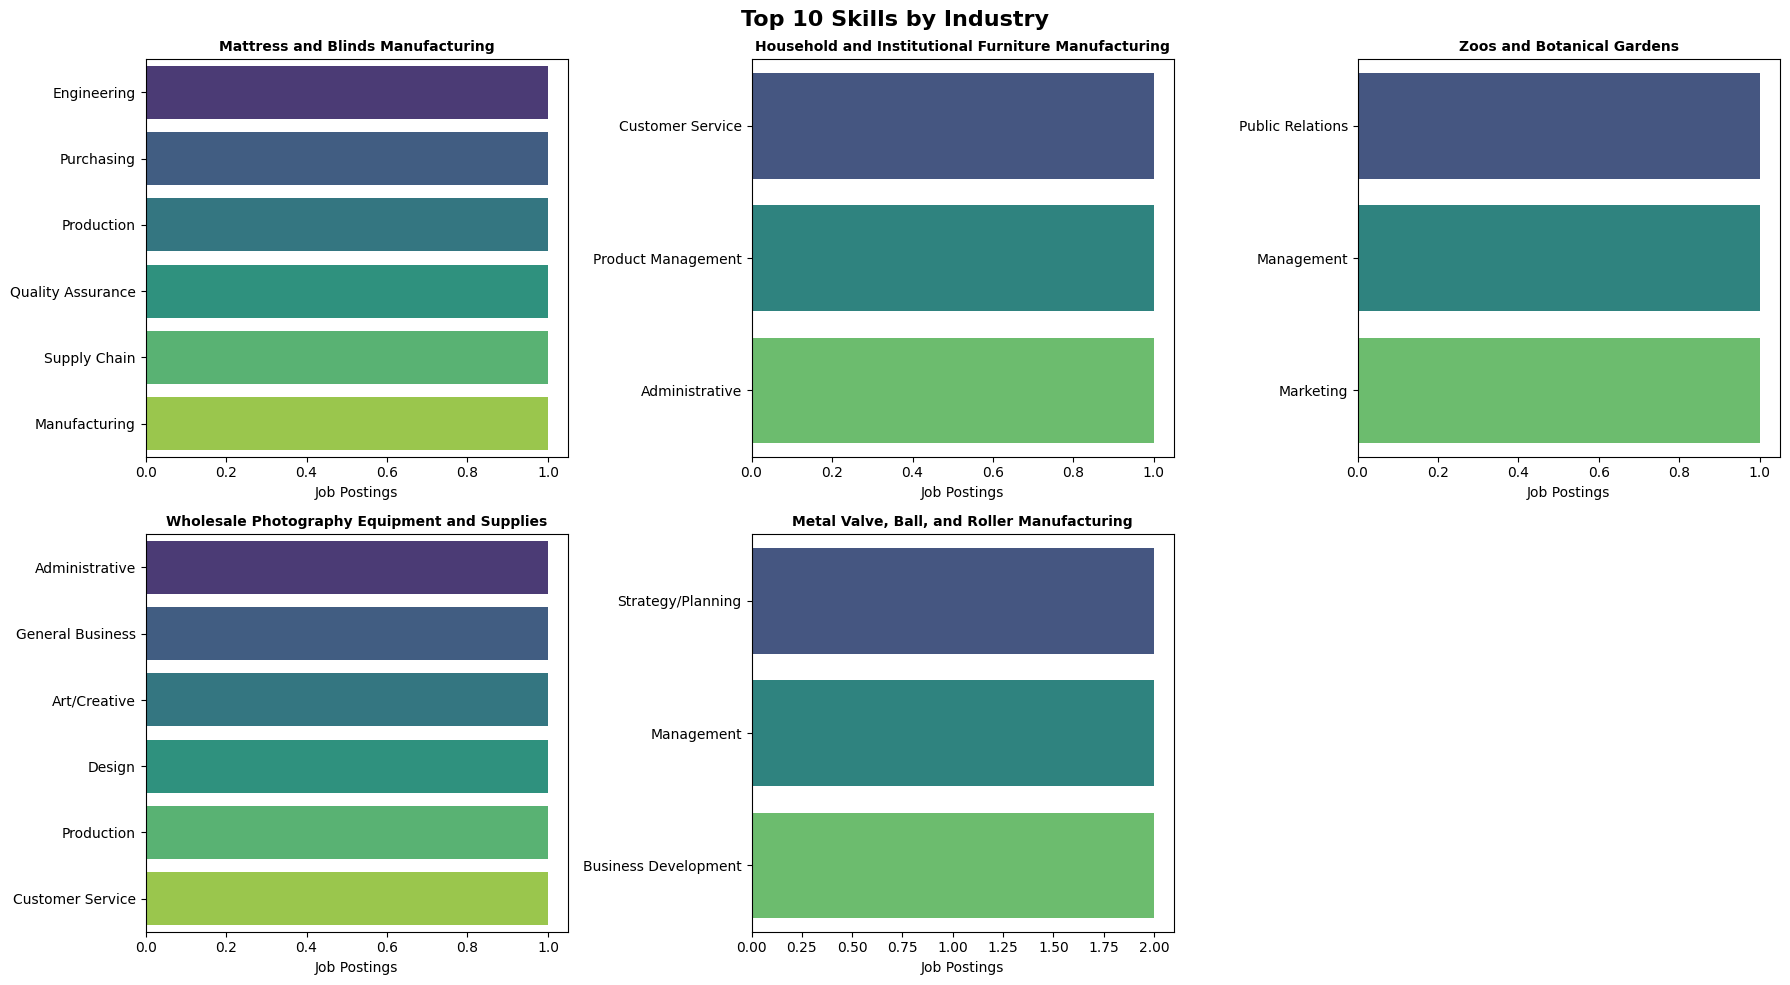

Visualization 1 saved!


In [12]:
# Create visuals directory
os.makedirs("../analytics_output/visuals", exist_ok=True)

# Plot 1: Top 10 Skills in Top 5 Industries
top_5_industries = avg_skills_pd.nlargest(5, 'avg_skills_required')['industry_name'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Top 10 Skills by Industry', fontsize=16, fontweight='bold')

for idx, industry in enumerate(top_5_industries):
    data = skills_by_industry_pd[skills_by_industry_pd['industry_name'] == industry].head(10)
    ax = axes[idx // 3, idx % 3]
    sns.barplot(data=data, y='skill_name', x='skill_count', ax=ax, palette='viridis')
    ax.set_title(f"{industry}", fontsize=10, fontweight='bold')
    ax.set_xlabel("Job Postings")
    ax.set_ylabel("")

# Hide the 6th subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig("../analytics_output/visuals/top_skills_by_industry.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 1 saved!")

/tmp/ipykernel_6102/2073025049.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_avg, y='industry_name', x='avg_skills_required', palette='magma')


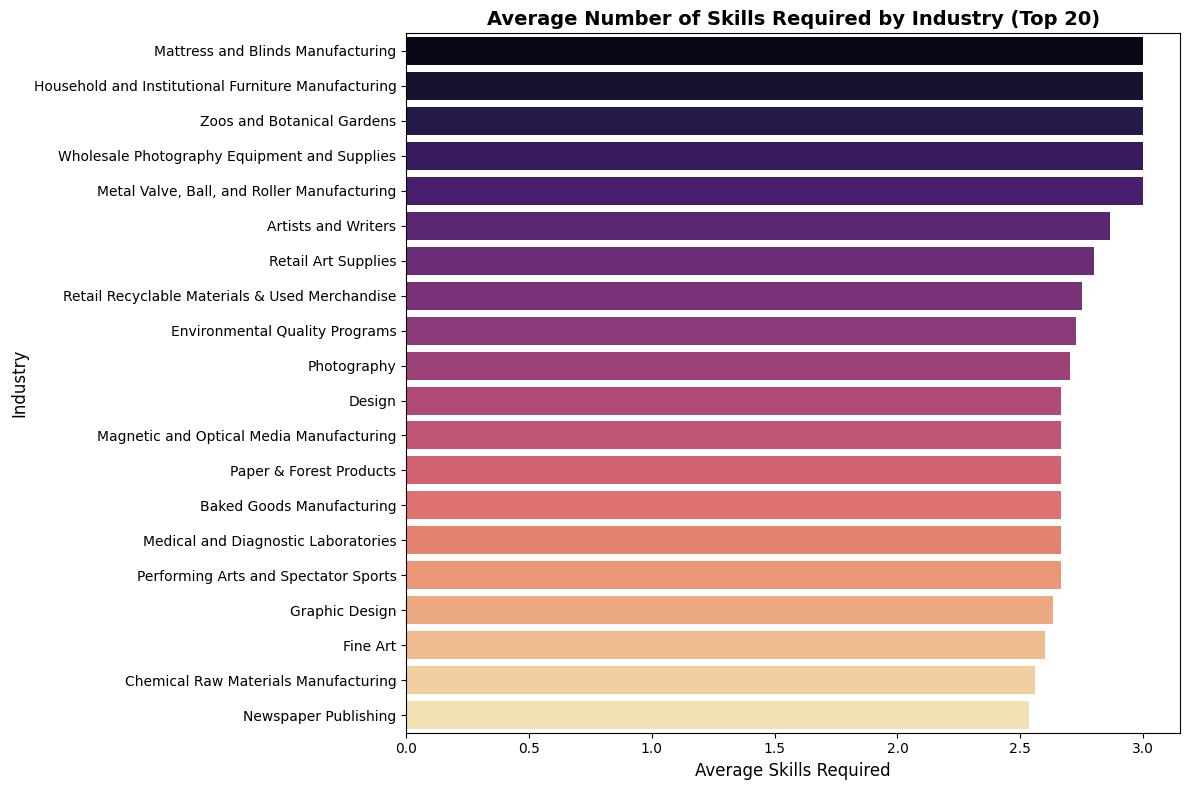

Visualization 2 saved!


In [13]:
# Plot 2: Average Skills Required by Industry
plt.figure(figsize=(12, 8))
top_20_avg = avg_skills_pd.head(20)
sns.barplot(data=top_20_avg, y='industry_name', x='avg_skills_required', palette='magma')
plt.title('Average Number of Skills Required by Industry (Top 20)', fontsize=14, fontweight='bold')
plt.xlabel('Average Skills Required', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.tight_layout()
plt.savefig("../analytics_output/visuals/avg_skills_by_industry.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 2 saved!")

/tmp/ipykernel_6102/3708197688.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_30_cross, y='skill_name', x='num_industries', palette='coolwarm')


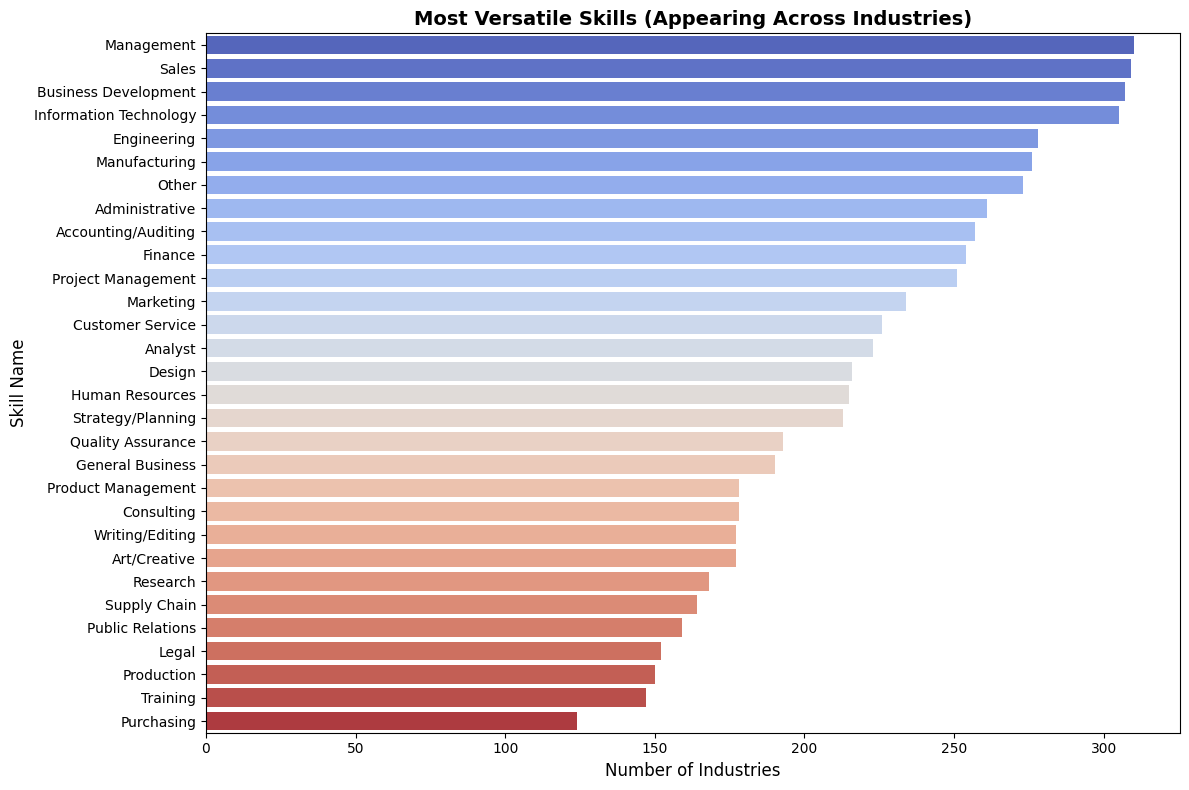

Visualization 3 saved!


In [14]:
# Plot 3: Cross-Industry Skills (Most Versatile Skills)
plt.figure(figsize=(12, 8))
top_30_cross = cross_industry_pd.head(30)
sns.barplot(data=top_30_cross, y='skill_name', x='num_industries', palette='coolwarm')
plt.title('Most Versatile Skills (Appearing Across Industries)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Industries', fontsize=12)
plt.ylabel('Skill Name', fontsize=12)
plt.tight_layout()
plt.savefig("../analytics_output/visuals/cross_industry_skills.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 3 saved!")

## 🎓 Student-Focused Market Analysis
### Enhanced Visualizations for Job Seekers

The following visualizations provide actionable insights for students and new graduates entering the job market.

### Visualization 4: Skill Co-occurrence Network
**Purpose:** Shows which skills are commonly required together in job postings.  
**Student Value:** Learn skill bundles efficiently - if SQL and Python appear together often, learn both for maximum job opportunities.

In [15]:
# Query: Find top 20 most common skill pairs
from pyspark.sql.functions import lit, concat_ws, array_sort, collect_list

# Get skills per job
skills_per_job = job_skills \
    .join(skill_map, "skill_abr") \
    .groupBy("job_id") \
    .agg(collect_list("skill_name").alias("skills"))

# Convert to pandas for analysis
skills_per_job_pd = skills_per_job.toPandas()

# Find skill pairs
from itertools import combinations
import pandas as pd

skill_pairs = []
for skills_list in skills_per_job_pd['skills']:
    if len(skills_list) >= 2:
        pairs = list(combinations(sorted(skills_list), 2))
        skill_pairs.extend(pairs)

# Count occurrences
pair_counts = pd.DataFrame(skill_pairs, columns=['Skill_1', 'Skill_2'])
pair_counts = pair_counts.groupby(['Skill_1', 'Skill_2']).size().reset_index(name='count')
top_pairs = pair_counts.nlargest(20, 'count')

print("=== Top 20 Skill Pairs ===")
print(top_pairs)

=== Top 20 Skill Pairs ===
                    Skill_1                 Skill_2  count
423              Management           Manufacturing  16336
170    Business Development                   Sales  13164
292             Engineering  Information Technology   9090
11      Accounting/Auditing                 Finance   3735
327                 Finance                   Sales   3569
462               Marketing                   Sales   2340
116                 Analyst                Research   2242
104                 Analyst  Information Technology   2196
396  Information Technology      Project Management   2144
400  Information Technology                Research   1959
286               Education                Training   1833
126            Art/Creative                  Design   1466
236                  Design  Information Technology   1441
131            Art/Creative  Information Technology   1368
224        Customer Service                   Sales   1335
458               Marketing  

/tmp/ipykernel_6102/2068097869.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs.head(15), y='pair_label', x='count', palette='rocket')


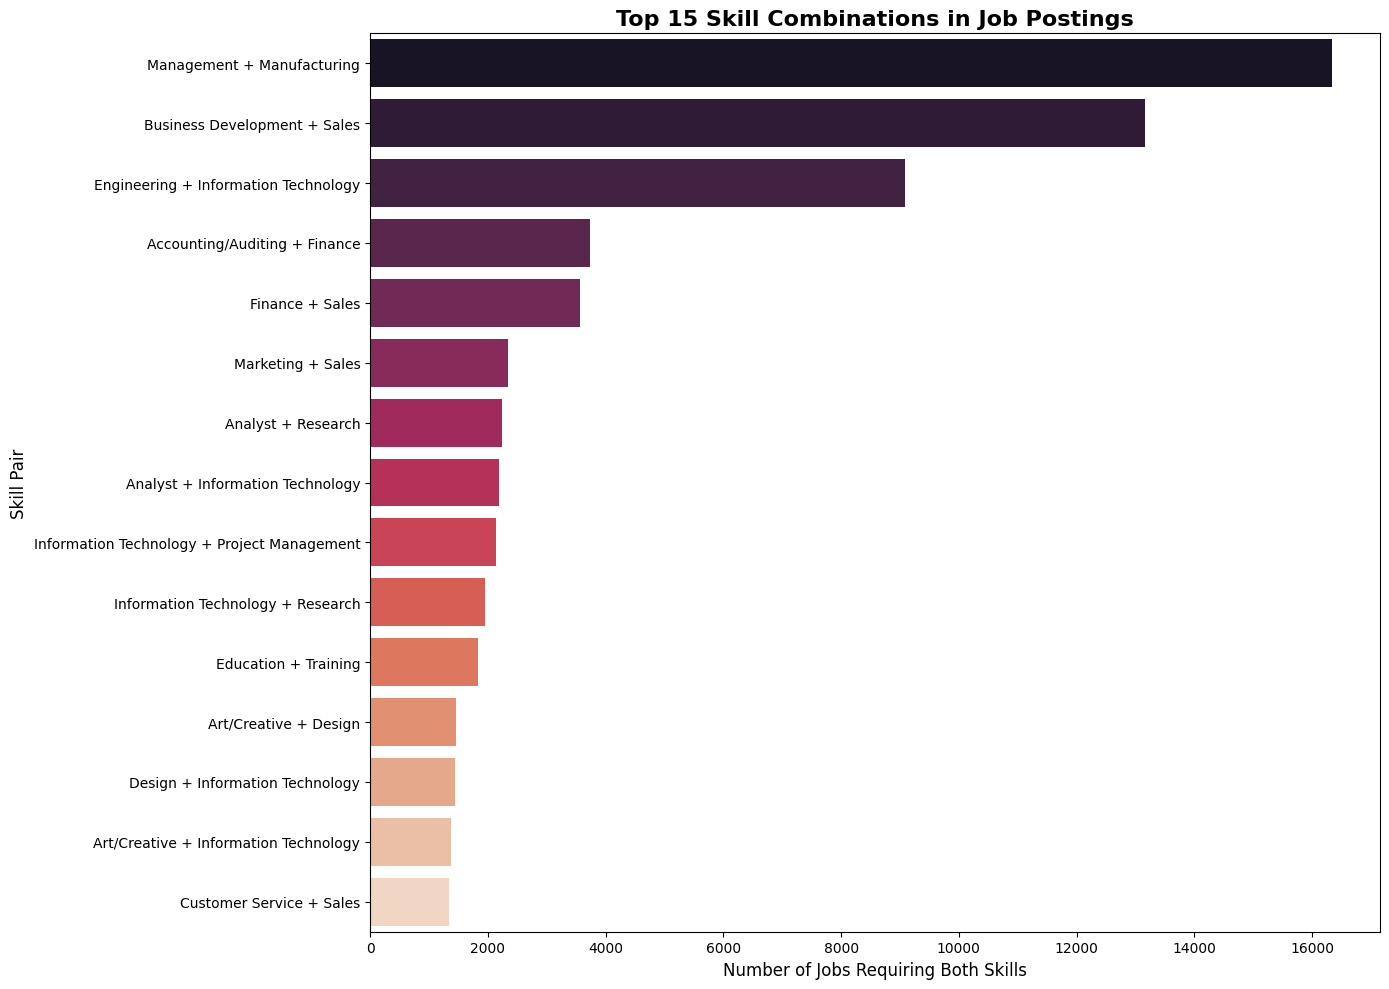

Skill Pairs Visualization saved!

INSIGHT FOR STUDENTS:
   Learn these skills together for maximum employability!
   Top combo: Management + Manufacturing
   (16336 jobs require both)


In [16]:
# Visualize skill pairs as a heatmap-style chart
plt.figure(figsize=(14, 10))

# Create a label for each pair
top_pairs['pair_label'] = top_pairs['Skill_1'] + ' + ' + top_pairs['Skill_2']

# Plot
sns.barplot(data=top_pairs.head(15), y='pair_label', x='count', palette='rocket')
plt.title('Top 15 Skill Combinations in Job Postings', fontsize=16, fontweight='bold')
plt.xlabel('Number of Jobs Requiring Both Skills', fontsize=12)
plt.ylabel('Skill Pair', fontsize=12)
plt.tight_layout()
plt.savefig("../analytics_output/visuals/skill_pairs.png", dpi=300, bbox_inches='tight')
plt.show()

print("Skill Pairs Visualization saved!")
print("\nINSIGHT FOR STUDENTS:")
print("   Learn these skills together for maximum employability!")
print(f"   Top combo: {top_pairs.iloc[0]['Skill_1']} + {top_pairs.iloc[0]['Skill_2']}")
print(f"   ({top_pairs.iloc[0]['count']} jobs require both)")

### Visualization 5: Top 10 Most In-Demand Skills Overall
**Purpose:** Shows the absolute most demanded skills across all industries.  
**Student Value:** Prioritize learning these skills first - they open the most doors.

In [17]:
# Query: Top 10 most demanded skills overall
top_skills_overall = job_skills \
    .join(skill_map, "skill_abr") \
    .groupBy("skill_name") \
    .agg(count("job_id").alias("job_count")) \
    .orderBy(desc("job_count")) \
    .limit(10)

print("=== Top 10 Most Demanded Skills ===")
top_skills_overall.show(truncate=False)

# Convert to pandas
top_skills_overall_pd = top_skills_overall.toPandas()

=== Top 10 Most Demanded Skills ===


+----------------------+---------+
|skill_name            |job_count|
+----------------------+---------+
|Information Technology|26137    |
|Sales                 |22475    |
|Management            |20861    |
|Manufacturing         |18185    |
|Health Care Provider  |17369    |
|Business Development  |14290    |
|Engineering           |13009    |
|Other                 |12608    |
|Finance               |8540     |
|Marketing             |5525     |
+----------------------+---------+



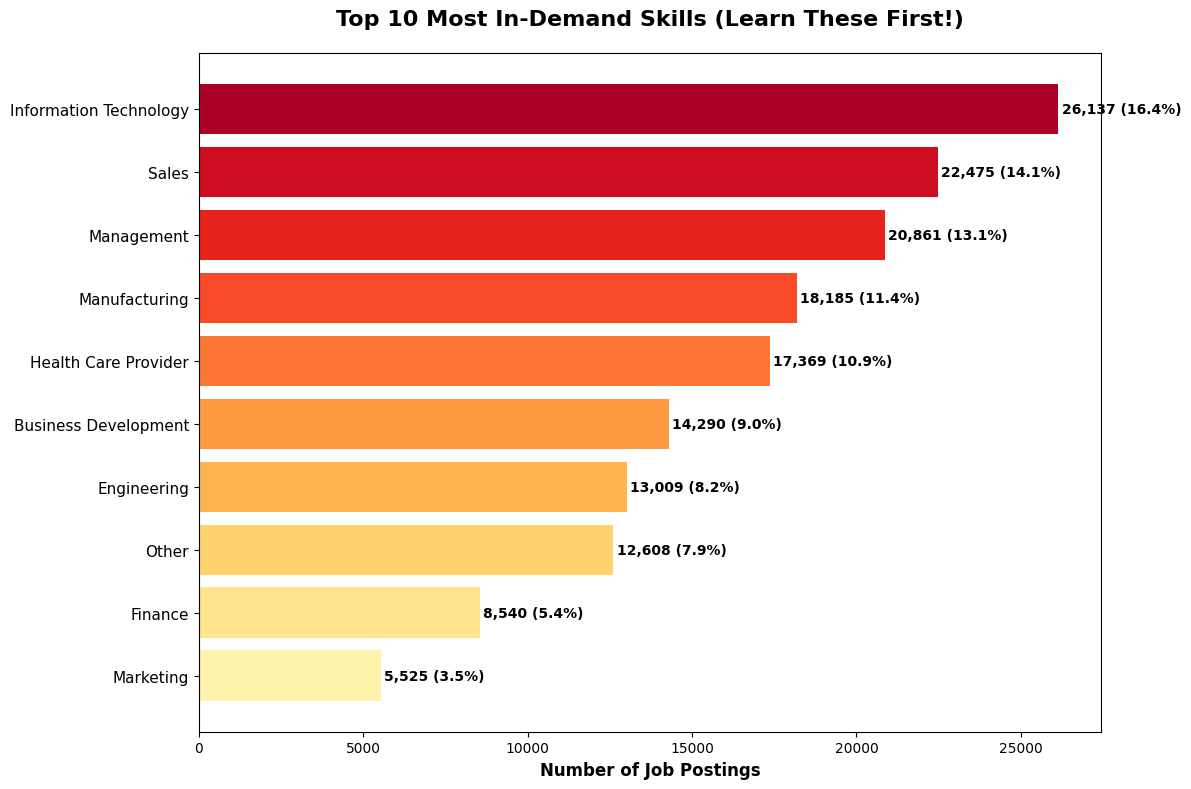

Top Skills Visualization saved!

CAREER TIP:
   The #1 most demanded skill is: Information Technology
   Found in 26,137 job postings!
   Master the top 3 skills to qualify for 43.6% of analyzed jobs


In [18]:
# Create an attractive visualization with percentages
plt.figure(figsize=(12, 8))

# Calculate percentages
total_skill_mentions = top_skills_overall_pd['job_count'].sum()
top_skills_overall_pd['percentage'] = (top_skills_overall_pd['job_count'] / total_skill_mentions * 100).round(1)

# Create horizontal bar chart with gradient
colors = sns.color_palette("YlOrRd_r", n_colors=10)
bars = plt.barh(range(10), top_skills_overall_pd['job_count'], color=colors)

# Add percentage labels
for i, (count, pct) in enumerate(zip(top_skills_overall_pd['job_count'], top_skills_overall_pd['percentage'])):
    plt.text(count + 100, i, f'{count:,} ({pct}%)', va='center', fontweight='bold', fontsize=10)

plt.yticks(range(10), top_skills_overall_pd['skill_name'], fontsize=11)
plt.xlabel('Number of Job Postings', fontsize=12, fontweight='bold')
plt.title('Top 10 Most In-Demand Skills (Learn These First!)', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.savefig("../analytics_output/visuals/top_10_skills_overall.png", dpi=300, bbox_inches='tight')
plt.show()

print("Top Skills Visualization saved!")
print("\nCAREER TIP:")
print(f"   The #1 most demanded skill is: {top_skills_overall_pd.iloc[0]['skill_name']}")
print(f"   Found in {top_skills_overall_pd.iloc[0]['job_count']:,} job postings!")
print(f"   Master the top 3 skills to qualify for {top_skills_overall_pd.head(3)['percentage'].sum():.1f}% of analyzed jobs")

### Visualization 6: Industry Entry Barriers (Skills Required Distribution)
**Purpose:** Shows how many skills different industries typically require.  
**Student Value:** Choose industries matching your current skill level or understand the gap to close.

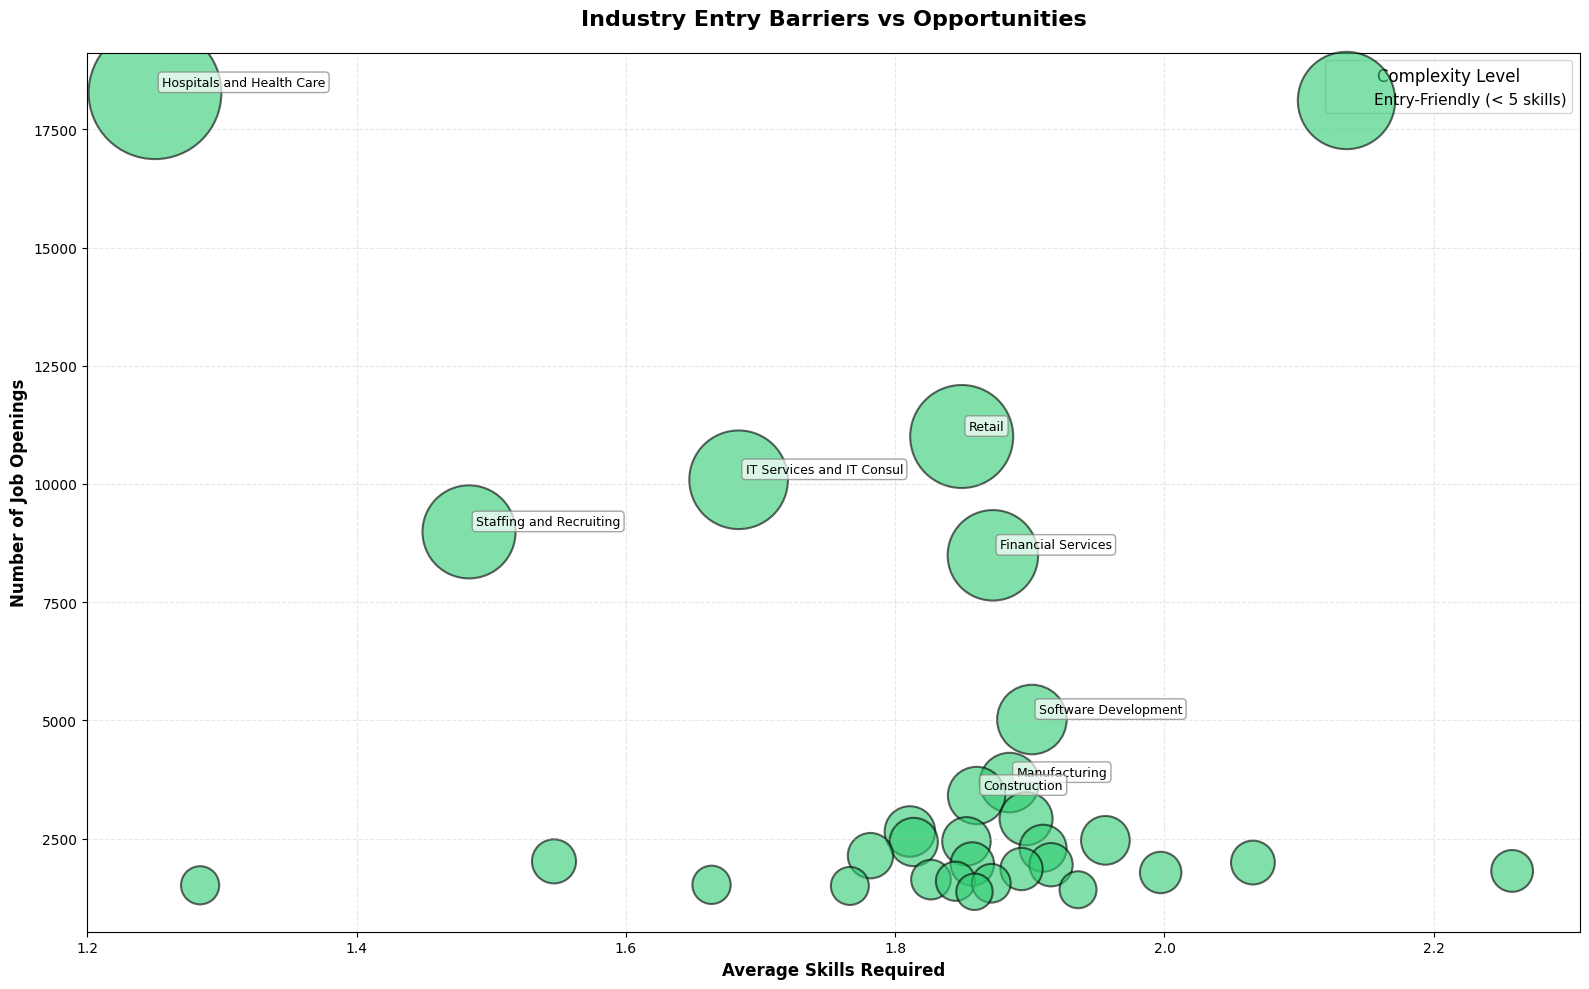

Industry Entry Barriers Visualization saved!

STRATEGY FOR STUDENTS:
   Entry-Friendly Industries (start here):
      - Hospitals and Health Care: ~1.3 skills, 18275 jobs
      - Retail: ~1.8 skills, 11004 jobs
      - IT Services and IT Consulting: ~1.7 skills, 10089 jobs
      - Staffing and Recruiting: ~1.5 skills, 8987 jobs
      - Financial Services: ~1.9 skills, 8491 jobs


In [19]:
# Create bubble chart showing industry complexity
# Use existing avg_skills_pd from earlier queries

# Prepare data for visualization - take top 30 industries by job count
industry_complexity = avg_skills_pd.copy()
industry_complexity = industry_complexity.nlargest(30, 'total_jobs')

# Create color categories based on skill requirements
def categorize_complexity(avg_skills):
    if avg_skills < 5:
        return 'Entry-Friendly (< 5 skills)'
    elif avg_skills < 7:
        return 'Moderate (5-7 skills)'
    else:
        return 'Advanced (7+ skills)'

industry_complexity['complexity'] = industry_complexity['avg_skills_required'].apply(categorize_complexity)

# Create visualization
colors_map = {
    'Entry-Friendly (< 5 skills)': '#2ecc71',
    'Moderate (5-7 skills)': '#f39c12', 
    'Advanced (7+ skills)': '#e74c3c'
}

fig, ax = plt.subplots(figsize=(16, 10))

# Plot each category
for category in ['Entry-Friendly (< 5 skills)', 'Moderate (5-7 skills)', 'Advanced (7+ skills)']:
    data = industry_complexity[industry_complexity['complexity'] == category]
    
    if len(data) > 0:
        ax.scatter(
            data['avg_skills_required'], 
            data['total_jobs'],
            s=data['total_jobs'] * 0.5,  # Bubble size proportional to jobs
            alpha=0.6,
            c=colors_map[category],
            label=category,
            edgecolors='black',
            linewidth=1.5
        )
        
        # Add industry labels for larger bubbles
        for idx, row in data.nlargest(8, 'total_jobs').iterrows():
            ax.annotate(
                row['industry_name'][:25],  # Truncate long names
                (row['avg_skills_required'], row['total_jobs']),
                fontsize=9,
                ha='left',
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray')
            )

ax.set_xlabel('Average Skills Required', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Job Openings', fontsize=12, fontweight='bold')
ax.set_title('Industry Entry Barriers vs Opportunities', fontsize=16, fontweight='bold', pad=20)
ax.legend(title='Complexity Level', fontsize=11, title_fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig("../analytics_output/visuals/industry_entry_barriers.png", dpi=300, bbox_inches='tight')
plt.show()

print("Industry Entry Barriers Visualization saved!")
print("\nSTRATEGY FOR STUDENTS:")
entry_friendly = industry_complexity[industry_complexity['avg_skills_required'] < 5].head(5)
if len(entry_friendly) > 0:
    print("   Entry-Friendly Industries (start here):")
    for idx, row in entry_friendly.iterrows():
        print(f"      - {row['industry_name']}: ~{row['avg_skills_required']:.1f} skills, {row['total_jobs']} jobs")
else:
    print("   Focus on building 5-7 core skills for moderate-entry industries")

### Visualization 7: Skill Diversity Index
**Purpose:** Shows which skills are specialized (narrow) vs generalist (broad).  
**Student Value:** Understand if a skill is a safe investment (used everywhere) or niche specialty.

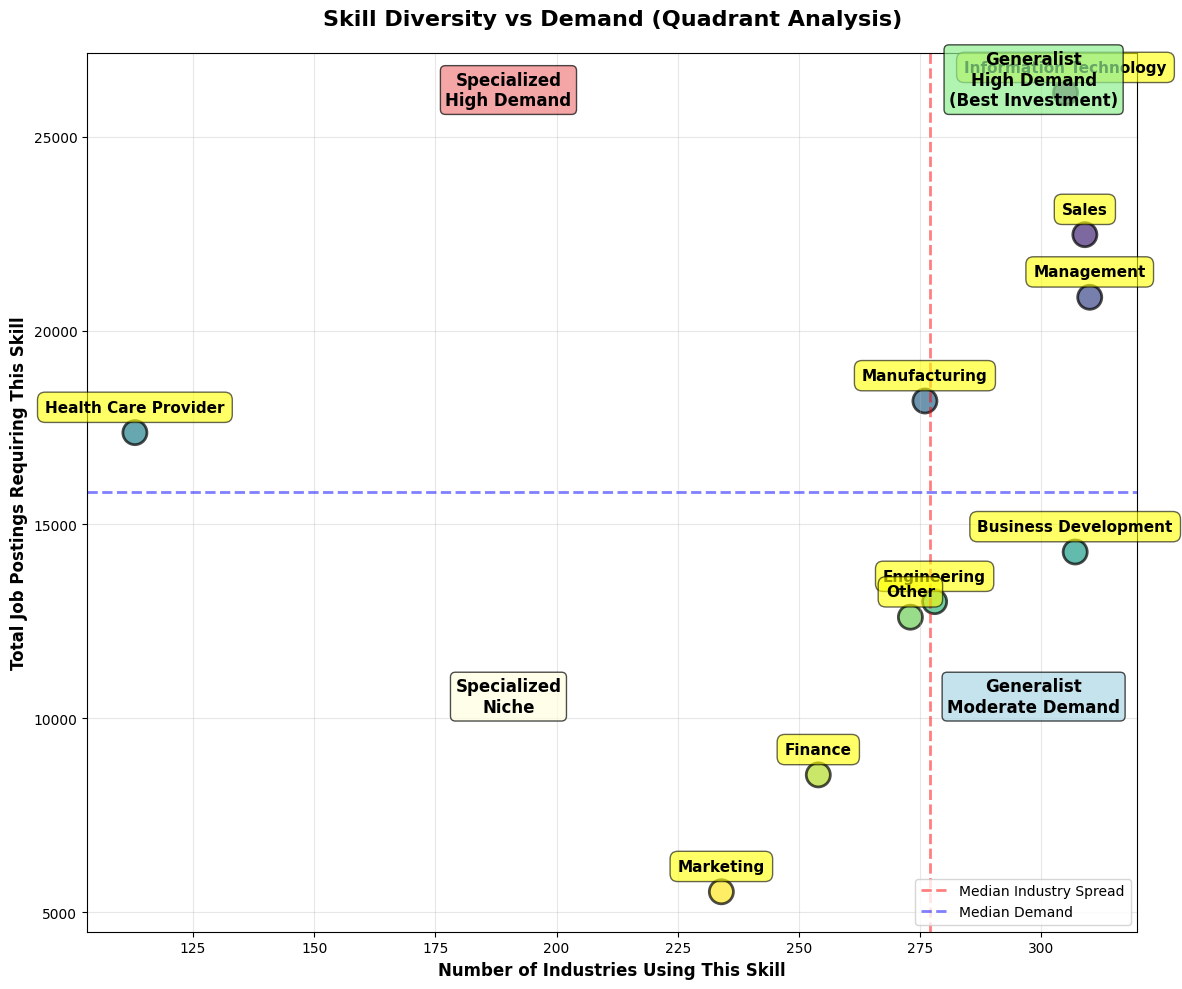

Skill Diversity Index Visualization saved!

LEARNING PRIORITY:
   BEST BET (Generalist + High Demand):
      - Information Technology: 305 industries, 26,137 jobs
      - Sales: 309 industries, 22,475 jobs
      - Management: 310 industries, 20,861 jobs


In [20]:
# Combine total demand with industry spread
skill_diversity = top_skills_overall_pd.merge(
    cross_industry_pd[['skill_name', 'num_industries']],
    on='skill_name',
    how='inner'  # Only skills in top 10
).head(10)

# Create quadrant chart
plt.figure(figsize=(12, 10))

# Scatter plot with different colors for each skill
scatter = plt.scatter(
    skill_diversity['num_industries'],
    skill_diversity['job_count'],
    s=300,
    c=range(len(skill_diversity)),
    cmap='viridis',
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

# Add labels for each skill
for idx, row in skill_diversity.iterrows():
    plt.annotate(
        row['skill_name'],
        (row['num_industries'], row['job_count']),
        fontsize=11,
        fontweight='bold',
        ha='center',
        xytext=(0, 15),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.6)
    )

# Add quadrant lines
median_industries = skill_diversity['num_industries'].median()
median_jobs = skill_diversity['job_count'].median()

plt.axvline(median_industries, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Median Industry Spread')
plt.axhline(median_jobs, color='blue', linestyle='--', alpha=0.5, linewidth=2, label='Median Demand')

# Add quadrant labels
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

plt.text(xlim[0] + (median_industries - xlim[0]) * 0.5, ylim[1] * 0.95, 
         'Specialized\nHigh Demand', ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
plt.text(median_industries + (xlim[1] - median_industries) * 0.5, ylim[1] * 0.95, 
         'Generalist\nHigh Demand\n(Best Investment)', ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
plt.text(xlim[0] + (median_industries - xlim[0]) * 0.5, ylim[0] + (median_jobs - ylim[0]) * 0.5, 
         'Specialized\nNiche', ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
plt.text(median_industries + (xlim[1] - median_industries) * 0.5, ylim[0] + (median_jobs - ylim[0]) * 0.5, 
         'Generalist\nModerate Demand', ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.xlabel('Number of Industries Using This Skill', fontsize=12, fontweight='bold')
plt.ylabel('Total Job Postings Requiring This Skill', fontsize=12, fontweight='bold')
plt.title('Skill Diversity vs Demand (Quadrant Analysis)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../analytics_output/visuals/skill_diversity_index.png", dpi=300, bbox_inches='tight')
plt.show()

print("Skill Diversity Index Visualization saved!")
print("\nLEARNING PRIORITY:")
print("   BEST BET (Generalist + High Demand):")
best_bets = skill_diversity[(skill_diversity['num_industries'] > median_industries) & 
                             (skill_diversity['job_count'] > median_jobs)]
if len(best_bets) > 0:
    for idx, row in best_bets.iterrows():
        print(f"      - {row['skill_name']}: {row['num_industries']} industries, {row['job_count']:,} jobs")
else:
    print("      All top skills show balanced diversity and demand")

### Visualization 8: Career Path Builder
**Purpose:** Shows learning progression - foundational skills vs advanced skills.  
**Student Value:** Build a learning roadmap from beginner to advanced based on market data.

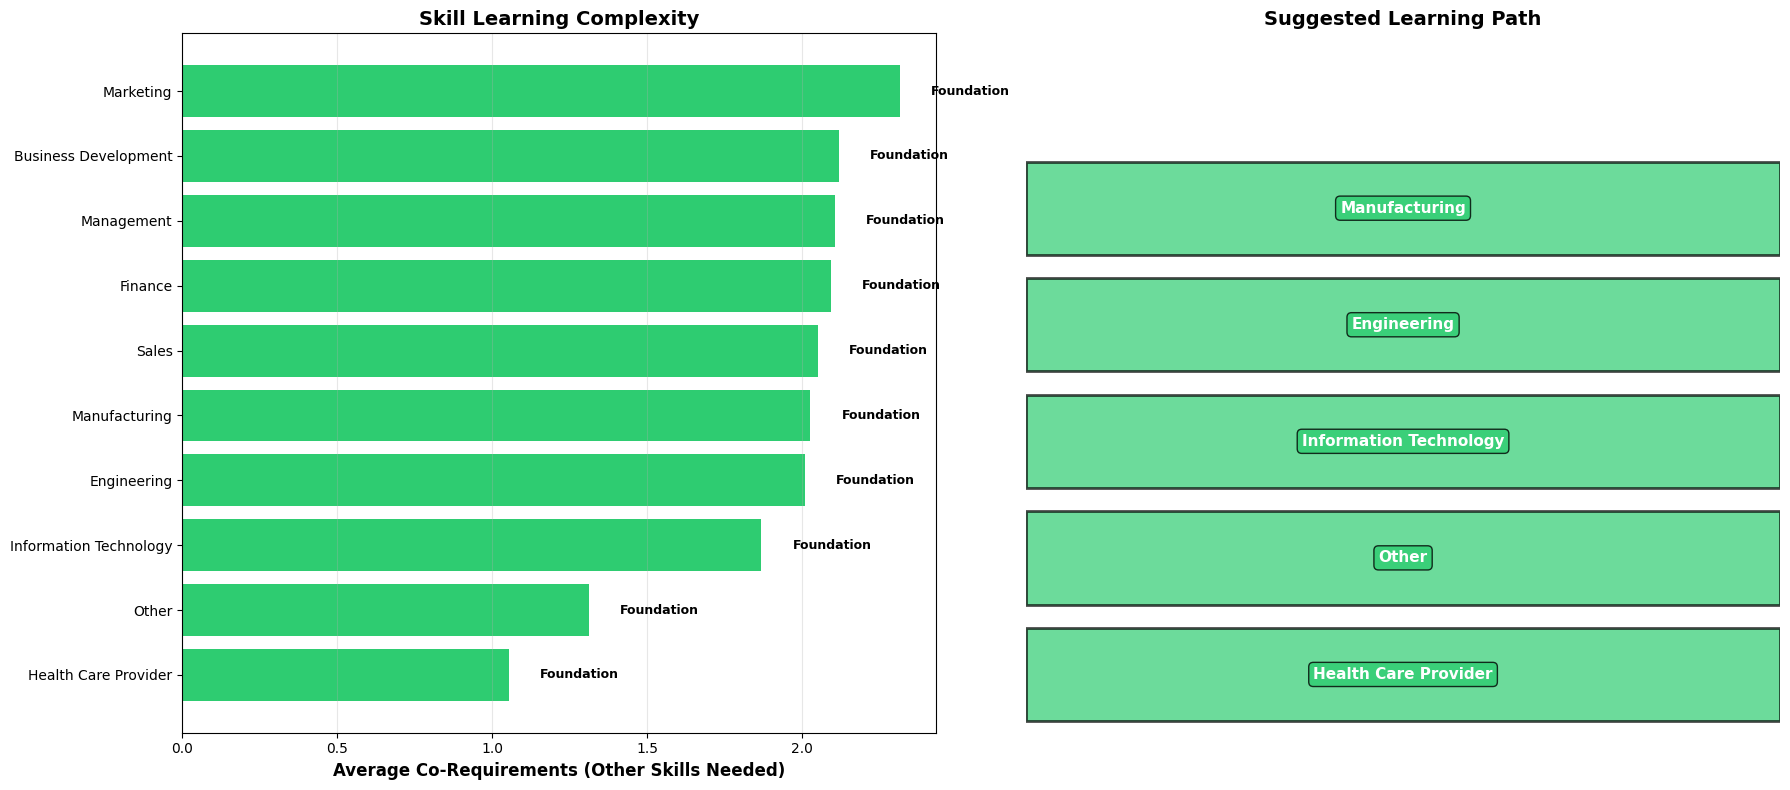

Career Path Builder Visualization saved!

YOUR LEARNING ROADMAP:

   FOUNDATION SKILLS (Learn First - Lower Prerequisites):
      - Health Care Provider
      - Other
      - Information Technology


In [21]:
# Analyze skill complexity based on how often they appear WITH other skills
# More co-requirements = more advanced/specialized
# Fewer co-requirements = more foundational/standalone

# Calculate average number of OTHER skills required when this skill is listed
skill_complexity_scores = []

for skill in top_skills_overall_pd['skill_name'].head(15):
    # Find jobs requiring this skill
    skill_jobs = skills_per_job_pd[skills_per_job_pd['skills'].apply(lambda x: skill in x)]
    
    if len(skill_jobs) > 0:
        # Calculate average number of skills in jobs requiring this skill
        avg_skills_in_job = skill_jobs['skills'].apply(len).mean()
        
        skill_complexity_scores.append({
            'skill': skill,
            'avg_co_requirements': avg_skills_in_job,
            'total_jobs': len(skill_jobs)
        })

complexity_df = pd.DataFrame(skill_complexity_scores).sort_values('avg_co_requirements')

# Categorize based on co-requirements
# Lower co-requirements = Foundation skills (can learn standalone)
# Higher co-requirements = Advanced skills (need other skills first)
complexity_df['level'] = pd.cut(
    complexity_df['avg_co_requirements'], 
    bins=[0, 4.5, 6.5, 20], 
    labels=['Foundation', 'Intermediate', 'Advanced']
)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Chart 1: Co-requirement scores
colors_level = {'Foundation': '#2ecc71', 'Intermediate': '#f39c12', 'Advanced': '#e74c3c'}
bars = ax1.barh(
    complexity_df['skill'], 
    complexity_df['avg_co_requirements'],
    color=[colors_level[level] for level in complexity_df['level']]
)
ax1.set_xlabel('Average Co-Requirements (Other Skills Needed)', fontsize=12, fontweight='bold')
ax1.set_title('Skill Learning Complexity', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add level labels
for idx, (skill, score, level) in enumerate(zip(complexity_df['skill'], 
                                                  complexity_df['avg_co_requirements'], 
                                                  complexity_df['level'])):
    ax1.text(score + 0.1, idx, f'{level}', va='center', fontsize=9, fontweight='bold')

# Chart 2: Learning path roadmap
foundation = complexity_df[complexity_df['level'] == 'Foundation']
intermediate = complexity_df[complexity_df['level'] == 'Intermediate']
advanced = complexity_df[complexity_df['level'] == 'Advanced']

y_pos = 0
for level_name, data, color in [('Foundation\n(Start Here)', foundation, '#2ecc71'),
                                  ('Intermediate\n(Build On)', intermediate, '#f39c12'),
                                  ('Advanced\n(Specialize)', advanced, '#e74c3c')]:
    if len(data) > 0:
        for skill in data['skill'].head(5):  # Max 5 per level
            ax2.barh(y_pos, 1, color=color, alpha=0.7, edgecolor='black', linewidth=2)
            ax2.text(0.5, y_pos, skill, ha='center', va='center', 
                    fontsize=11, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))
            y_pos += 1
        y_pos += 0.5  # Gap between levels

ax2.set_xlim(0, 1)
ax2.set_ylim(-0.5, y_pos)
ax2.axis('off')
ax2.set_title('Suggested Learning Path', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("../analytics_output/visuals/career_path_builder.png", dpi=300, bbox_inches='tight')
plt.show()

print("Career Path Builder Visualization saved!")
print("\nYOUR LEARNING ROADMAP:")
if len(foundation) > 0:
    print("\n   FOUNDATION SKILLS (Learn First - Lower Prerequisites):")
    for skill in foundation['skill'].head(3):
        print(f"      - {skill}")
if len(intermediate) > 0:
    print("\n   INTERMEDIATE SKILLS (Build On Foundation):")
    for skill in intermediate['skill'].head(3):
        print(f"      - {skill}")
if len(advanced) > 0:
    print("\n   ADVANCED SKILLS (Specialize & Stand Out):")
    for skill in advanced['skill'].head(3):
        print(f"      - {skill}")

## 📋 Student Action Plan Summary
### Key Takeaways & Next Steps

In [22]:
# Generate a comprehensive student action plan
print("="*70)
print("PERSONALIZED JOB MARKET ACTION PLAN FOR STUDENTS")
print("="*70)

print("\nVISUALIZATION SUMMARY:")
print("   - 8 Total Visualizations Created")
print("   - All saved to: ../analytics_output/visuals/")
print("\n   1. Top Skills by Industry - Industry-specific skill requirements")
print("   2. Average Skills by Industry - Entry barriers analysis")
print("   3. Cross-Industry Skills - Transferable skills identification")
print("   4. Skill Pairs - Learn complementary skills together")
print("   5. Top 10 Overall Skills - Priority learning list")
print("   6. Entry Barriers - Industry accessibility vs opportunity")
print("   7. Skill Diversity Index - Specialist vs generalist skills")
print("   8. Career Path Builder - Foundation to Advanced progression")

print("\n" + "="*70)
print("YOUR 90-DAY ACTION PLAN")
print("="*70)

print("\nMONTH 1: Build Foundation")
print("   Focus on the top 3 most demanded skills:")
if len(top_skills_overall_pd) >= 3:
    for i in range(3):
        skill = top_skills_overall_pd.iloc[i]
        print(f"      {i+1}. {skill['skill_name']}")
        print(f"         Found in {skill['job_count']:,} jobs ({skill['percentage']:.1f}% of market)")

print("\nMONTH 2: Add Complementary Skills")
print("   Learn these skill combinations together:")
if len(top_pairs) >= 3:
    for i in range(min(3, len(top_pairs))):
        pair = top_pairs.iloc[i]
        print(f"      - {pair['Skill_1']} + {pair['Skill_2']}")
        print(f"        {pair['count']} jobs require both")

print("\nMONTH 3: Choose Your Path")
print("   Select an industry based on:")
if len(industry_complexity) > 0:
    entry_industries = industry_complexity[industry_complexity['avg_skills_required'] < 5].head(3)
    if len(entry_industries) > 0:
        print("   Entry-Friendly Options:")
        for idx, row in entry_industries.iterrows():
            print(f"      - {row['industry_name']}")
            print(f"        Skills needed: ~{row['avg_skills_required']:.1f}")
            print(f"        Job openings: {row['total_jobs']}")

print("\n" + "="*70)
print("IMMEDIATE NEXT STEPS")
print("="*70)
print("   1. Review all 8 visualizations in ../analytics_output/visuals/")
print("   2. Pick your target industry from Visualization 6")
print("   3. Learn the top 3 skills from Visualization 5")
print("   4. Build skill pairs from Visualization 4")
print("   5. Follow the learning path in Visualization 8")
print("   6. Apply to jobs in entry-friendly industries first")

print("\n" + "="*70)
print("SUCCESS METRICS TO TRACK")
print("="*70)
print("   [ ] Master 3 foundation skills in 30 days")
print("   [ ] Complete 1 skill pair (complementary skills) in 60 days")
print("   [ ] Apply to 5 entry-friendly industry jobs in 90 days")
print("   [ ] Build portfolio project using top 5 skills")
print("   [ ] Network with professionals in chosen industry")

print("\n" + "="*70)
print("REMEMBER: You don't need ALL skills, just the RIGHT skills!")
print("="*70)

# Save action plan to file
with open("../analytics_output/STUDENT_ACTION_PLAN.txt", "w", encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("PERSONALIZED JOB MARKET ACTION PLAN FOR STUDENTS\n")
    f.write("="*70 + "\n\n")
    f.write("Generated from LinkedIn Job Market Analysis\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n\n")
    
    f.write("TOP 10 MOST DEMANDED SKILLS:\n")
    for idx, row in top_skills_overall_pd.iterrows():
        f.write(f"   {idx+1}. {row['skill_name']}: {row['job_count']:,} jobs\n")
    
    f.write("\n\nTOP SKILL COMBINATIONS:\n")
    for idx, row in top_pairs.head(10).iterrows():
        f.write(f"   - {row['Skill_1']} + {row['Skill_2']}: {row['count']} jobs\n")
    
    f.write("\n\nENTRY-FRIENDLY INDUSTRIES:\n")
    entry_industries = industry_complexity[industry_complexity['avg_skills_required'] < 5].head(5)
    for idx, row in entry_industries.iterrows():
        f.write(f"   - {row['industry_name']}: ~{row['avg_skills_required']:.1f} skills, {row['total_jobs']} openings\n")

print("\nStudent action plan saved to: ../analytics_output/STUDENT_ACTION_PLAN.txt")

PERSONALIZED JOB MARKET ACTION PLAN FOR STUDENTS

VISUALIZATION SUMMARY:
   - 8 Total Visualizations Created
   - All saved to: ../analytics_output/visuals/

   1. Top Skills by Industry - Industry-specific skill requirements
   2. Average Skills by Industry - Entry barriers analysis
   3. Cross-Industry Skills - Transferable skills identification
   4. Skill Pairs - Learn complementary skills together
   5. Top 10 Overall Skills - Priority learning list
   6. Entry Barriers - Industry accessibility vs opportunity
   7. Skill Diversity Index - Specialist vs generalist skills
   8. Career Path Builder - Foundation to Advanced progression

YOUR 90-DAY ACTION PLAN

MONTH 1: Build Foundation
   Focus on the top 3 most demanded skills:
      1. Information Technology
         Found in 26,137 jobs (16.4% of market)
      2. Sales
         Found in 22,475 jobs (14.1% of market)
      3. Management
         Found in 20,861 jobs (13.1% of market)

MONTH 2: Add Complementary Skills
   Learn thes

## Summary Statistics for Demo

In [23]:
print("="*60)
print("COMPLEX QUERIES SUMMARY")
print("="*60)
print(f"\nTotal Industries Analyzed: {industry_map_clean.count()}")
print(f"Total Unique Skills: {skill_map.count()}")
print(f"Total Job Postings: {postings.count()}")
print(f"\nQuery 1: Identified top 10 skills for each industry")
print(f"Query 2: Calculated average skills required across {avg_skills_pd.shape[0]} industries")
print(f"Query 3: Found {cross_industry_pd.shape[0]} skills used across industries")
print(f"\nAll results saved to: ../analytics_output/query_results/")
print(f"All visualizations saved to: ../analytics_output/visuals/")
print("="*60)

COMPLEX QUERIES SUMMARY

Total Industries Analyzed: 388
Total Unique Skills: 35


Total Job Postings: 1160234

Query 1: Identified top 10 skills for each industry
Query 2: Calculated average skills required across 388 industries
Query 3: Found 35 skills used across industries

All results saved to: ../analytics_output/query_results/
All visualizations saved to: ../analytics_output/visuals/


In [24]:
# Stop Spark session
# spark.stop()